 # Integración de clustering para mejorar la clasificación de lenguaje ofensivo

Se trabajó sobre el dataset de OffenseEval 2020. Este consiste de 13240 tweets etiquetados
para entrenamiento y 860 para testing.

La tarea principal es entrenar un clasificador que sea capaz de reconocer lenguaje ofensivo
codificando los tweets, realizando clustering sobre dicha representación, y según su pureza
agregarlos como *features* para del modelo.

In [2]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# Fasttext
import fasttext

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

# Sklearn, XGBoost, and other models
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Utils
from models import NN
from joblib import dump

 ## Exploración de datos

In [3]:
train_df = pd.read_csv(f"dataset/processed/offenseval_train.csv")
test_df = pd.read_csv(f"dataset/processed/offenseval_test.csv")

In [4]:
train_df

,id,tweet,label_name,label
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0
...,...,...,...,...
13202,95338,@USER Sometimes I get strong vibes from people...,OFF,1
13203,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,0
13204,82921,@USER And why report this garbage. We don't g...,OFF,1
13205,27429,@USER Pussy,OFF,1


In [5]:
test_df

,id,tweet,label_name,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,1
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,0
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,0
3,13876,#Watching #Boomer getting the news that she is...,NOT,0
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,1
...,...,...,...,...
844,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,1
845,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,0
846,67018,3 people just unfollowed me for talking about ...,OFF,1
847,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,0


<AxesSubplot:xlabel='label_name', ylabel='count'>

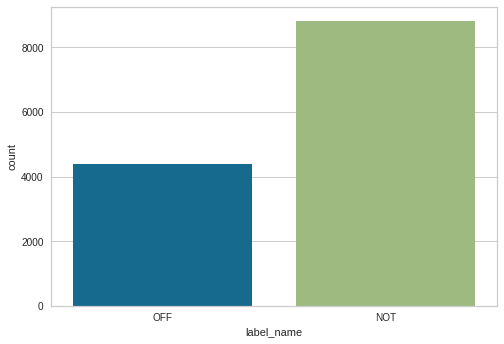

In [6]:
sns.histplot(train_df["tweet"].apply(lambda t: len(t)))
sns.histplot(test_df["tweet"].apply(lambda t: len(t)))
sns.countplot(data=train_df, x="label_name")

Preprocesamiento aplicado al dataset:

  - Mención de usuarios por un tag @USER.
  - Emojis se dejan intactos.
  - Reestructuración del conjunto de datos
  - Eliminación de tweets duplicados en los dos conjuntos.

 ## Codificación de tweets

In [7]:
def unsupervised_data_gen(sentences, corpus_file):
    with open(corpus_file, "w") as out:
        for s in sentences:
            out.write(s + "\n")

off_sentences = train_df.loc[train_df["label_name"] == "OFF", "tweet"]
mixed_sentences = train_df["tweet"].sample(5000)

unsupervised_data_gen(off_sentences, "offensive_sentences.txt")
unsupervised_data_gen(mixed_sentences, "mixed_sentences.txt")

model_off = fasttext.train_unsupervised("offensive_sentences.txt",
                                        model="cbow",
                                        lr=0.3,
                                        epoch=100,
                                        dim=100,
                                        wordNgrams=4,
                                        ws=4)
model_mixed = fasttext.train_unsupervised("mixed_sentences.txt",
                                          model="cbow",
                                          lr=0.3,
                                          epoch=100,
                                          dim=100,
                                          wordNgrams=4,
                                          ws=4)

train_df = train_df.assign(
    vec_off=train_df["tweet"].apply(lambda t: model_off.get_sentence_vector(t)),
    vec_mixed=train_df["tweet"].apply(lambda t: model_mixed.get_sentence_vector(t))
)
test_df = test_df.assign(
    vec_off=test_df["tweet"].apply(lambda t: model_off.get_sentence_vector(t)),
    vec_mixed=test_df["tweet"].apply(lambda t: model_mixed.get_sentence_vector(t))
)

Read 0M words
Number of words:  2140
Number of labels: 0
Progress: 100.0% words/sec/thread:  124490 lr:  0.000000 avg.loss: 20.863031 ETA:   0h 0m 0s
Read 0M words
Number of words:  2187
Number of labels: 0
Progress: 100.0% words/sec/thread:  140091 lr:  0.000000 avg.loss: 22.410555 ETA:   0h 0m 0s


 ## Clustering
 - Kmeans con ofensivos y no ofensivos
 - Métricas de pureza

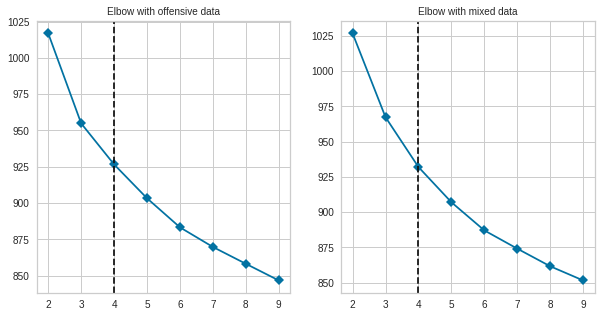

<Figure size 576x396 with 0 Axes>

In [8]:
def plot_elbow(X,
               metric,
               k_range,
               ax,
               title="Elbow Plot",
               title_size=10,
               tick_size=10):
    visualizer = KElbowVisualizer(KMeans(),
                                  k=k_range,
                                  metric=metric,
                                  timings=False,
                                  ax=ax)
    visualizer.fit(X)
    ax.set_title(title, fontsize=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)

_, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_elbow(X=np.vstack(train_df["vec_off"]),
           k_range=(2, 10),
           metric="distortion",
           title="Elbow with offensive data",
           ax=axes[0])
plot_elbow(X=np.vstack(train_df["vec_mixed"]),
           k_range=(2, 10),
           metric="distortion",
           title="Elbow with mixed data",
           ax=axes[1])
plt.show()
plt.clf()

In [9]:
kmeans_off = KMeans(n_clusters=4)
kmeans_off.fit(np.vstack(train_df["vec_off"]))

kmeans_mixed = KMeans(n_clusters=5)
kmeans_mixed.fit(np.vstack(train_df["vec_mixed"]))

train_df = train_df.assign(cluster_off=kmeans_off.labels_)
train_df = train_df.assign(cluster_mixed=kmeans_mixed.labels_)

test_df = test_df.assign(
    cluster_off=kmeans_off.predict(np.vstack(test_df["vec_off"])))
test_df = test_df.assign(
    cluster_mixed=kmeans_mixed.predict(np.vstack(test_df["vec_mixed"])))

In [10]:
pd.crosstab(train_df["label"], train_df["cluster_off"])

cluster_off,0,1,2,3
label,,,,
0,740,5413,510,2152
1,280,3072,97,943


In [11]:
pd.crosstab(train_df["label"], train_df["cluster_mixed"])

cluster_mixed,0,1,2,3,4
label,,,,,
0,754,1672,5062,823,504
1,264,693,2961,371,103


 ## Clasificación
 - Fasttext con todos los datos + LGR o XGBoost o NN
 - Fasttext con datos offensivos + LGR o XGBoost o NN

In [12]:
runs = [
     (LogisticRegression(), {
         "class_weight": ["balanced"],
         "penalty": ["elasticnet"],
         "C": [1, 0.01],
         "solver": ["saga"],
         "max_iter": [1000],
         "l1_ratio": [0, 1, 0.5]
     }),
     (XGBClassifier(), {
         "objective": ["binary:logistic"],
         "n_estimators": [500],
         "gamma": [0.001, 1],
         "max_depth": [20],
         "booster": ["gbtree"],
         "eval_metric": ["logloss"],
         "use_label_encoder": [False],
         "lambda": [0.001, 1]
     }),
    (NN(), {
        "h_size": [32, 64],
        "n_layers": [4, 8],
        "bn_bool": [False],
        "p": [0.2],
        "epochs": [20],
        "batch_size": [32],
        "lr": [0.001],
        "weight_decay": [0]
    }),
]
vec_names = ["vec_off", "vec_mixed"]
experiments = []
for vec_name in vec_names:
    X_train, y_train = np.vstack(
        train_df[vec_name]), train_df["label"].to_numpy()
    X_test, y_test = np.vstack(test_df[vec_name]), test_df["label"].to_numpy()

    results = { }
    for model, grid in runs:
        clf = GridSearchCV(
            estimator=model,
            param_grid=grid,
            scoring="f1",
            refit=True,
            cv=5,
            verbose=3
        )
        clf.fit(X_train, y_train)
        y_pred = clf.best_estimator_.predict(X_test)
        results["model_name"] = model.__class__.__name__
        results["vector"] = vec_name
        results["params"] = clf.best_params_
        results["score"] = f1_score(y_test, y_pred)
        results["pred"] = y_pred
        experiments.append(results)
        dump(clf.best_estimator_, f"{model.__class__.__name__}__{vec_name}.joblib")

experiments_df = pd.DataFrame(experiments)
experiments_df.to_csv("results.csv", index=False)

001, max_depth=20, n_estimators=500, objective=binary:logistic, use_label_encoder=False;, score=0.342 total time=  47.3s
[CV 3/5] END booster=gbtree, eval_metric=logloss, gamma=0.001, lambda=0.001, max_depth=20, n_estimators=500, objective=binary:logistic, use_label_encoder=False;, score=0.352 total time=  47.5s
[CV 4/5] END booster=gbtree, eval_metric=logloss, gamma=0.001, lambda=0.001, max_depth=20, n_estimators=500, objective=binary:logistic, use_label_encoder=False;, score=0.341 total time=  46.2s
[CV 5/5] END booster=gbtree, eval_metric=logloss, gamma=0.001, lambda=0.001, max_depth=20, n_estimators=500, objective=binary:logistic, use_label_encoder=False;, score=0.347 total time=  47.6s
[CV 1/5] END booster=gbtree, eval_metric=logloss, gamma=0.001, lambda=1, max_depth=20, n_estimators=500, objective=binary:logistic, use_label_encoder=False;, score=0.344 total time=  51.8s
[CV 2/5] END booster=gbtree, eval_metric=logloss, gamma=0.001, lambda=1, max_depth=20, n_estimators=500, object

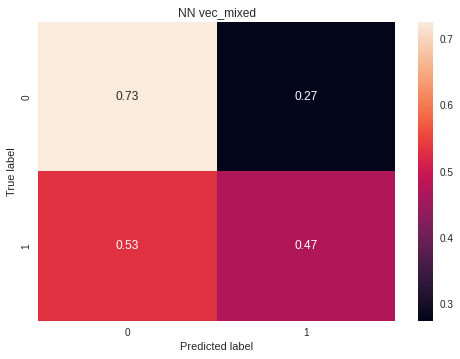

<Figure size 576x396 with 0 Axes>

In [13]:
experiments_df.assign(cm=experiments_df["pred"].apply(
    lambda pred: confusion_matrix(y_test, pred)))
nof_experiments = len(experiments_df)

best_results_df = experiments_df.iloc[experiments_df["score"].argmax()]

cm = confusion_matrix(y_test, best_results_df["pred"])
cm = cm / np.sum(cm, axis=1).reshape(-1, 1)
sns.heatmap(cm, annot=True)
plt.title(f"{best_results_df['model_name']} {best_results_df['vector']}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
plt.clf()

 ## Clasificación con etiquetas dada por clustering
 - Solo training set con datos ofensivos

Training epochs: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


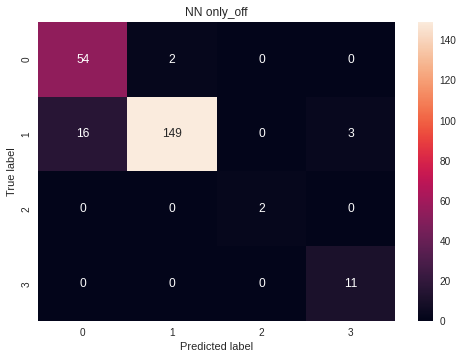

['NN__vec_off__off.joblib']

<Figure size 576x396 with 0 Axes>

In [21]:
train_off_df = train_df[train_df["label_name"] == "OFF"]
test_off_df = test_df[test_df["label_name"] == "OFF"]

model = NN()
params = {
    "h_size": 64,
    "n_layers": 8,
    "bn_bool": False,
    "p": 0.2,
    "epochs": 20,
    "batch_size": 32,
    "lr": 0.001,
    "weight_decay": 0
}

X_train_off, y_train_off = np.vstack(
    train_off_df["vec_off"]), train_off_df["cluster_off"].to_numpy()
X_test_off, y_test_off = np.vstack(
    test_off_df["vec_off"]), test_off_df["cluster_off"].to_numpy()

model.set_params(**params)
model.fit(X_train_off, y_train_off)
y_pred_off = model.predict(X_test_off)

cm = confusion_matrix(y_test_off, y_pred_off)
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"NN only_off")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
plt.clf()

dump(model, f"{model.__class__.__name__}__vec_off__off.joblib")

In [1]:
# ## Trabajo a Futuro

  - Revisar con más atención si en los clusters ofensivos logramos reconocer algún subtipo de este.
  - Undersampling manual en lugar de que el modelo lo realice por sí mismo.
  - Probar otras configuracioes de Fasttext o diferentes embeddings que mejoren los clusters iniciales
    y puedan ser usados como features en la tarea de clasificación.

# ## Si tuviera un equipo de 3 personas y un año

  - Corroborar otras formas de preprocesamiento,
  - Parametrizaciones más complejas corriendo sobre computadores dedicados.
  - Pipeline con MLflow.

IndentationError: unexpected indent (<ipython-input-1-99d803968b7a>, line 3)